In [8]:
# Define autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Adopted from Andrew's project

from training_defs import load_spectral_data, get_dataloaders
from model import MLP
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

X, y = load_spectral_data()
train_loader, val_loader = get_dataloaders(X, y)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Layers
hidden_layers = [64, 128, 128, 62]

model = MLP(in_dim=X.shape[1], h_dim=hidden_layers, out_dim=3).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
lconst_mult = 0.1
train_losses, val_losses = [], []

In [ ]:
for epoch in range(1, n_epochs+1):
    model.train()
    tot_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss_pred = criterion(model(xb), yb)
        loss_pred.backward()
        optimizer.step()

        l_constraint = (float(sum(model(xb)[0])) + float(sum(model(xb)[1]))) - 2
        # Sum of the two floats should add up to 2. Not sure why there are two outputs yet...

        loss = loss_pred + (lconst_mult * l_constraint)
        tot_train += loss.item() * xb.size(0)
    train_losses.append(tot_train / len(train_loader.dataset))

    model.eval()
    tot_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            tot_val += criterion(model(xb), yb).item() * xb.size(0)
    val_losses.append(tot_val / len(val_loader.dataset))

    print(f"epoch {epoch:02d}  train loss: {train_losses[-1]:.4f}  val loss: {val_losses[-1]:.4f}")

0.9970356822013855 tensor(0.9908, grad_fn=<AddBackward0>)
epoch 01  train loss: 0.1159  val loss: 0.0604
0.9994943141937256 tensor(1.0075, grad_fn=<AddBackward0>)
epoch 02  train loss: 0.1164  val loss: 0.0589
0.9976081252098083 tensor(0.9875, grad_fn=<AddBackward0>)
epoch 03  train loss: 0.1174  val loss: 0.0598
0.9955315589904785 tensor(0.9991, grad_fn=<AddBackward0>)
epoch 04  train loss: 0.1167  val loss: 0.0595
1.004285454750061 tensor(0.9969, grad_fn=<AddBackward0>)
epoch 05  train loss: 0.1163  val loss: 0.0592
0.9852496385574341 tensor(1.1069, grad_fn=<AddBackward0>)
epoch 06  train loss: 0.1170  val loss: 0.0609
0.9890786409378052 tensor(1.0040, grad_fn=<AddBackward0>)
epoch 07  train loss: 0.1217  val loss: 0.0610
1.009042501449585 tensor(1.0149, grad_fn=<AddBackward0>)
epoch 08  train loss: 0.1193  val loss: 0.0598
0.9884046316146851 tensor(1.0001, grad_fn=<AddBackward0>)
epoch 09  train loss: 0.1175  val loss: 0.0571
1.0064055919647217 tensor(1.0071, grad_fn=<AddBackward0>)

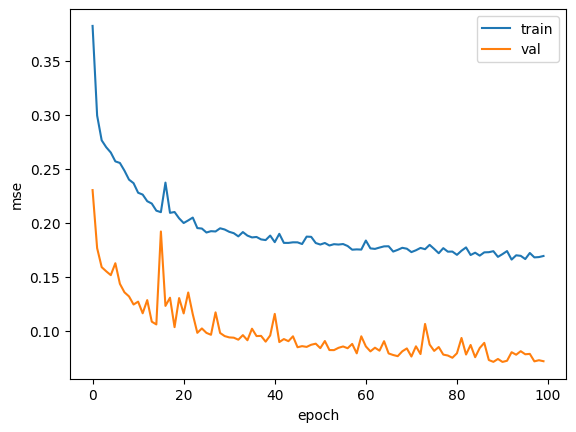

In [12]:
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("epoch"); plt.ylabel("mse"); plt.legend(); plt.show()

torch.save(model.state_dict(), "spectra_mlp.pth")

In [13]:
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

r2 = r2_score(all_targets, all_preds, multioutput="uniform_average")
rmse = root_mean_squared_error(all_targets, all_preds)

print(f"validation r^2:  {r2:.4f}")
print(f"validation rmse: {rmse:.4f}")

validation r^2:  0.8643
validation rmse: 0.1065
